In [462]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from utils import rmspe

In [608]:
import torch 
from torch import optim

In [609]:
from sklearn.model_selection import train_test_split

In [610]:
train_targets = pd.read_csv('train.csv')

In [611]:
import os
import re
stock_ids = sorted(
    [int(re.sub('stock_id=', '', x)) for x in os.listdir('book_train.parquet')])


In [612]:
stock_id = stock_ids[0]

In [613]:
book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))

In [614]:
book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
book['log_price'] = np.log(book['wap'])
book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
book['square_return'] = book['log_return'] ** 2
book = book[~book['log_return'].isnull()]
book['stock_id'] = stock_id

In [615]:
book = pd.merge(book, train_targets, how='left', on=['time_id', 'stock_id'])

In [616]:
X = pd.pivot_table(book, 
                   values='square_return', 
                   columns=['seconds_in_bucket'], 
                   index='time_id', aggfunc='last')

X = X.fillna(0)
y = train_targets[train_targets.stock_id == stock_id].set_index('time_id')['target'].loc[X.index]

In [622]:
np.delete(range(600), X.columns)

array([0])

In [556]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = torch.tensor(X_train.values)
X_test = torch.tensor(X_test.values)

y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

In [547]:
weights = torch.ones(X_train.shape[1], requires_grad=True)

In [548]:
def my_loss(y_true, y_pred):
    return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

In [549]:
opt = optim.Adam([weights], lr=0.01)
alpha = 0.8
beta = 1

In [550]:
train_loss_history = []
test_loss_history = []

In [551]:

for n in range(2000):
    y_pred = torch.matmul(X_train, weights) ** 0.5
    y_pred_test = torch.matmul(X_test, weights) ** 0.5
    
    
    reg = weights[:-1] - weights[1: ]
    loss = my_loss(y_train, y_pred) + torch.sum(reg[reg > 0] ** 2) * alpha + torch.sum(weights[weights < 0] ** 2)
    
    loss_train = my_loss(y_train, y_pred)
    loss_test = my_loss(y_test, y_pred_test)
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    train_loss_history.append(float(loss_train.detach().numpy()))
    test_loss_history.append(float(loss_test.detach().numpy()))

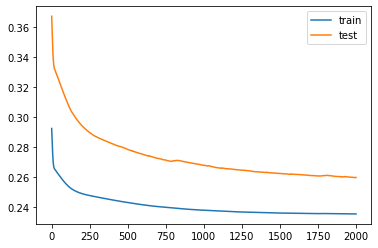

In [552]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)

plt.legend(['train', 'test'])

In [553]:
test_loss_history[0] - test_loss_history[-1]

0.10769544071685738

In [554]:
train_loss_history[0] - train_loss_history[-1]

0.057045836231917973

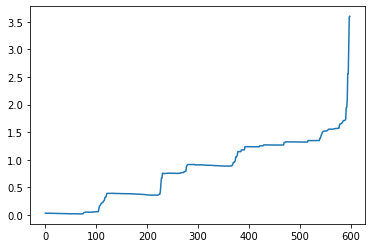

In [555]:
plt.plot(weights.detach().numpy())

In [607]:
res = {}

for stock_id in tqdm(stock_ids[:1]):
    book = pd.read_parquet('book_test.parquet/stock_id=' + str(stock_id))
    book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
    book['log_price'] = np.log(book['wap'])
    book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
    book['square_return'] = book['log_return'] ** 2
    book = book[~book['log_return'].isnull()]
    book['stock_id'] = stock_id
    
    book = pd.merge(book, train_targets, how='left', on=['time_id', 'stock_id'])
    
    X = pd.pivot_table(book, 
                   values='square_return', 
                   columns=['seconds_in_bucket'], 
                   index='time_id', aggfunc='last')

    X = X.fillna(0)
    y = train_targets[train_targets.stock_id == stock_id].set_index('time_id')['target'].loc[X.index]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    X_train = torch.tensor(X_train.values)
    X_test = torch.tensor(X_test.values)

    y_train = torch.tensor(y_train.values)
    y_test = torch.tensor(y_test.values)
    
    X = torch.tensor(X.values)
    y = torch.tensor(y.values)
    
    weights = torch.ones(X_train.shape[1], requires_grad=True)
    opt = optim.Adam([weights], lr=0.01)
    alpha = 0.8
    beta = 1
    
    for n in range(2000):
        y_pred = torch.matmul(X_train, weights) ** 0.5

        reg = weights[:-1] - weights[1: ]
        loss = my_loss(y_train, y_pred) + torch.sum(reg[reg > 0] ** 2) * alpha +torch.sum(
            weights[weights < 0] ** 2)

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    res[stock_id] = (weights, X, y, X_train, y_train, X_test, y_test)

  0%|          | 0/1 [00:00<?, ?it/s]


KeyError: "None of [Int64Index([4], dtype='int64', name='time_id')] are in the [index]"

In [584]:
y_true = []
y_pred = []

weights = res[stock_id][0]
for stock_id in res:
    X = res[stock_id][5]
    y = res[stock_id][6]
    
    y_true.append(y.detach().numpy())
    y_pred.append((torch.matmul(X, weights) ** 0.5).detach().numpy())

In [585]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [586]:
rmspe(y_true, y_pred)

0.2790782247939971

In [588]:
X = pd.pivot_table(book, 
               values='square_return', 
               columns=['seconds_in_bucket'], 
               index='time_id', aggfunc='last')

In [600]:
weights.shape

torch.Size([599])